In [1]:
import os, math, random, time, warnings, contextlib, csv
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.metrics import classification_report, accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T, models

from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize

import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

from sklearn.metrics import confusion_matrix
import textwrap, os
import seaborn as sns 
from torchvision.transforms.functional import to_pil_image

warnings.filterwarnings("ignore")
torch.backends.cudnn.benchmark = True

In [2]:
# Device selection
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", DEVICE)


Device:  cuda


In [3]:
# Config & Setup

warnings.filterwarnings("ignore", message=r".lr_scheduler\.step.*optimizer\.step.")

# ---- knobs ----
LR = LR_PRE if 'LR_PRE' in globals() else (LR_PRETRAIN if 'LR_PRETRAIN' in globals() else 3e-4)
WARMUP_FRAC = WARMUP_FRAC if 'WARMUP_FRAC' in globals() else 0.10
WEIGHT_DECAY = 1e-4
VAL_EVERY = 2

# Linear eval hyperparams -
LR_LIN     = globals().get("LR_LIN", 1e-3)   
PATIENCE   = globals().get("PATIENCE", 10)  

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)

# CSVs and images
IMG_ROOT = os.environ.get("EUROSAT_IMG_ROOT", "/kaggle/input/eurosat-dataset/EuroSAT")
CSV_ROOT = os.environ.get("EUROSAT_CSV_ROOT", "/kaggle/input/test-train-validation-csvs")

TRAIN_CSV = os.environ.get("TRAIN_CSV", "train.csv")
VAL_CSV   = os.environ.get("VAL_CSV",   "validation.csv")
TEST_CSV  = os.environ.get("TEST_CSV",  "test.csv")

# Training sizes
IMG_SIZE        = int(os.environ.get("IMG_SIZE", 224))
BATCH_SIZE_PRE  = int(os.environ.get("BATCH_SIZE_PRE", 64))   
BATCH_SIZE_LIN  = int(os.environ.get("BATCH_SIZE_LIN", 64))
EPOCHS_PRE      = int(os.environ.get("EPOCHS_PRE", 100))
EPOCHS_LIN      = int(os.environ.get("EPOCHS_LIN", 100))

# MoCo v2 specifics
QUEUE_SIZE      = int(os.environ.get("QUEUE_SIZE", 4096))   # multiple of BATCH_SIZE_PRE
MOMENTUM_ENC    = float(os.environ.get("MOMENTUM_ENC", 0.996))
TEMP            = float(os.environ.get("TEMP", 0.2))

# ---- checkpoint paths (load from dataset; save to working dir) ----
CKPT_LOAD_DIR = Path(os.environ.get("CKPT_LOAD_DIR", "/kaggle/input/moco-ckpts-v3"))
LAST_PRE_PATH_LOAD       = str(CKPT_LOAD_DIR / "moco_pretrain_last.pth")
BEST_PRETRAIN_FULL_LOAD  = str(CKPT_LOAD_DIR / "moco_pretrain_best_full.pth")

CKPT_SAVE_DIR = Path(os.environ.get("CKPT_SAVE_DIR", "/kaggle/working/moco_ckpt_v3")); CKPT_SAVE_DIR.mkdir(parents=True, exist_ok=True)
BEST_ENC_PATH            = str(CKPT_SAVE_DIR / "moco_encoder_q_best.pth")           # encoder_q only
BEST_PRETRAIN_FULL_PATH  = str(CKPT_SAVE_DIR / "moco_pretrain_best_full.pth")
LAST_PRE_PATH_SAVE       = str(CKPT_SAVE_DIR / "moco_pretrain_last.pth")

# Prefer resuming from the current run's working dir if files exist
CANDIDATE_LOADS = [
    Path(LAST_PRE_PATH_SAVE),        # /kaggle/working/.../moco_pretrain_last.pth
    Path(BEST_PRETRAIN_FULL_PATH),   # /kaggle/working/.../moco_pretrain_best_full.pth
    Path(LAST_PRE_PATH_LOAD),        # /kaggle/input/.../moco_pretrain_last.pth
    Path(BEST_PRETRAIN_FULL_LOAD),   # /kaggle/input/.../moco_pretrain_best_full.pth
]

# Checkpoint helpers 
def _atomic_save(obj, path):
    p = Path(path); tmp = p.with_suffix(p.suffix + ".tmp")
    torch.save(obj, tmp); os.replace(tmp, p)   # atomic write

GLOBAL_STEP = GLOBAL_STEP if 'GLOBAL_STEP' in globals() else 0  # per-step scheduler alignment

In [4]:
# CSV Loading 
EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff", ".webp", ".gif")

def _pick_col(df, candidates):
    lower = {c.lower(): c for c in df.columns}
    for cand in candidates:
        if cand in df.columns: return cand
        if cand.lower() in lower: return lower[cand.lower()]
    return None

def _looks_like_filename(s: str) -> bool:
    s = str(s); return any(s.lower().endswith(ext) for ext in EXTS)

def _ensure_path_col(df):
    c = _pick_col(df, ["path","image","img","filepath","file","filename"])
    if c is not None and df[c].map(_looks_like_filename).mean() > 0.5:
        return c
    raise ValueError("Could not locate an image path column; expected a 'path' column or similar.")

def _class_name_from_path(p): return os.path.basename(os.path.dirname(str(p)))

def _load_csv(name):
    df = pd.read_csv(os.path.join(CSV_ROOT, name))
    pcol = _ensure_path_col(df)
    def _join_maybe(x):
        x = str(x)
        if x.startswith("/") or ":" in x: return x
        return os.path.join(IMG_ROOT, x)
    df["path"] = df[pcol].map(_join_maybe)
    return df

train_df = _load_csv(TRAIN_CSV)
val_df   = _load_csv(VAL_CSV)
test_df  = _load_csv(TEST_CSV)

all_names = pd.concat([
    train_df["path"].map(_class_name_from_path),
    val_df["path"].map(_class_name_from_path),
    test_df["path"].map(_class_name_from_path)
], axis=0)

classes = {name: i for i, name in enumerate(sorted(all_names.unique()))}

for df_ in (train_df, val_df, test_df):
    df_["label"] = df_["path"].map(lambda p: classes[_class_name_from_path(p)]).astype(int)

num_classes = len(classes)
print(f"Classes: {num_classes} | class ids: 0..{num_classes-1}")

Classes: 10 | class ids: 0..9


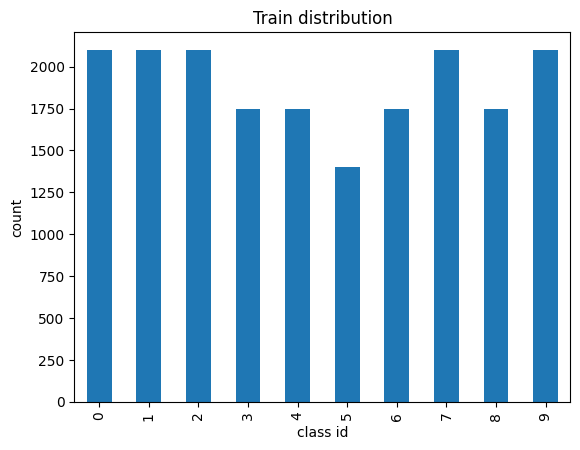

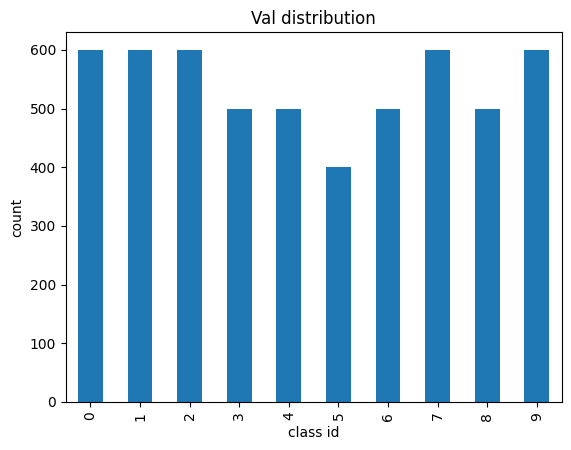

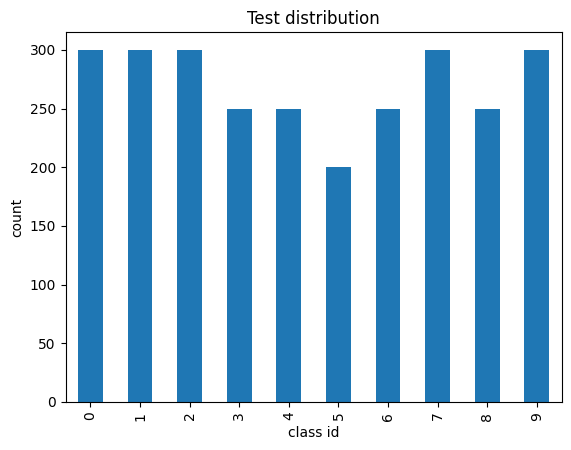

In [5]:
# Count plots: class distribution in train/val/test
import matplotlib.pyplot as plt

def _bar_counts(df, title):
    ax = df["label"].value_counts().sort_index().plot(kind="bar")
    ax.set_title(title); ax.set_xlabel("class id"); ax.set_ylabel("count")
    plt.show()

_bar_counts(train_df, "Train distribution")
_bar_counts(val_df, "Val distribution")
_bar_counts(test_df, "Test distribution")


In [6]:
# DataLoader performance knobs
_has_cuda = (torch.cuda.is_available() if 'torch' in globals() else False)
NUM_WORKERS_AUTO = (2 if _has_cuda else 0)
PIN_MEMORY_AUTO = bool(_has_cuda)
PERSISTENT_WORKERS_AUTO = bool(NUM_WORKERS_AUTO > 0)
PREFETCH_FACTOR_AUTO = (2 if NUM_WORKERS_AUTO > 0 else None)

# Datasets & DataLoaders

def auto_workers():
    cpu = os.cpu_count() or 4
    return max(4, min(12, cpu))

k = 7  # blur kernel
base_aug = T.Compose([
    T.RandomResizedCrop(IMG_SIZE, scale=(0.35, 1.0)),
    T.RandomHorizontalFlip(),
    T.RandomApply([T.ColorJitter(0.3, 0.3, 0.3, 0.1)], p=0.5),
    T.RandomGrayscale(p=0.08),
    T.RandomApply([T.GaussianBlur(kernel_size=k, sigma=(0.1, 1.0))], p=0.25),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

class PairTransform:
    def __init__(self, base_tf): self.base_tf = base_tf
    def __call__(self, img):
        return self.base_tf(img), self.base_tf(img)

train_transform = PairTransform(base_aug)

eval_transform  = T.Compose([
    T.Resize(IMG_SIZE + 32),
    T.CenterCrop(IMG_SIZE),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

def _load_rgb(path): return Image.open(path).convert("RGB")

class PairDataset(Dataset):
    def __init__(self, df, transform, cache=True):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self._cache_imgs = [ _load_rgb(p) for p in df["path"].tolist() ] if cache else None
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        img = self._cache_imgs[idx] if self._cache_imgs is not None else _load_rgb(self.df["path"].iloc[idx])
        x1, x2 = self.transform(img)
        return x1, x2, self.df["label"].iloc[idx]

class ImageDataset(Dataset):
    def __init__(self, df, transform, cache=True):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self._cache_imgs = [ _load_rgb(p) for p in df["path"].tolist() ] if cache else None
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        img = self._cache_imgs[idx] if self._cache_imgs is not None else _load_rgb(self.df["path"].iloc[idx])
        x = self.transform(img)
        return x, self.df["label"].iloc[idx]

train_pair_loader = DataLoader(PairDataset(train_df, train_transform, cache=True), batch_size=BATCH_SIZE_PRE, shuffle=True,  num_workers=auto_workers(), pin_memory=True, drop_last=True,  persistent_workers=True, prefetch_factor=2)
val_pair_loader   = DataLoader(PairDataset(val_df,   train_transform, cache=True), batch_size=BATCH_SIZE_PRE, shuffle=False, num_workers=auto_workers(), pin_memory=True, drop_last=True,  persistent_workers=True, prefetch_factor=2)

train_cls_loader  = DataLoader(ImageDataset(train_df, eval_transform, cache=True), batch_size=BATCH_SIZE_LIN, shuffle=True,  num_workers=auto_workers(), pin_memory=True, drop_last=False, persistent_workers=True, prefetch_factor=2)
val_cls_loader    = DataLoader(ImageDataset(val_df,   eval_transform, cache=True), batch_size=BATCH_SIZE_LIN, shuffle=False, num_workers=auto_workers(), pin_memory=True, drop_last=False, persistent_workers=True, prefetch_factor=2)
test_cls_loader   = DataLoader(ImageDataset(test_df,  eval_transform, cache=True), batch_size=BATCH_SIZE_LIN, shuffle=False, num_workers=auto_workers(), pin_memory=True, drop_last=False, persistent_workers=True, prefetch_factor=2)

In [7]:
# Model: DenseNet121 encoder + MLP projection head

def densenet121_encoder():
    m = models.densenet121(weights=None)
    m.classifier = nn.Identity()   # remove final classifier layer
    return m


class ProjectionHead(nn.Module):
    def __init__(self, in_dim=1024, hid_dim=1024, out_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(inplace=True),
            nn.Linear(hid_dim, out_dim)
        )
    def forward(self, x): 
        return F.normalize(self.net(x), dim=1)


# Online (query) encoder
encoder_q = densenet121_encoder().to(DEVICE)
proj_q    = ProjectionHead().to(DEVICE)

# Momentum (key) encoder
encoder_k = densenet121_encoder().to(DEVICE)
proj_k    = ProjectionHead().to(DEVICE)

for p_q, p_k in zip(encoder_q.parameters(), encoder_k.parameters()):
    p_k.data.copy_(p_q.data); p_k.requires_grad_(False)
for p_q, p_k in zip(proj_q.parameters(), proj_k.parameters()):
    p_k.data.copy_(p_q.data); p_k.requires_grad_(False)


In [8]:
# MoCo Core (Queue + Momentum + InfoNCE)

class MoCoQueue(nn.Module):
    def __init__(self, dim: int = 128, K: int = 65536):
        super().__init__()
        self.K = int(K)
        self.register_buffer("queue", F.normalize(torch.randn(dim, K), dim=0))
        self.register_buffer("ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def dequeue_and_enqueue(self, keys: torch.Tensor):
        keys = F.normalize(keys.detach(), dim=1).to(self.queue.device, non_blocking=True)
        bsz  = keys.size(0)
        if self.K % bsz != 0:
            raise ValueError(f"K ({self.K}) must be a multiple of batch size ({bsz}).")
        ptr = int(self.ptr)
        self.queue[:, ptr:ptr+bsz] = keys.T
        self.ptr[0] = (ptr + bsz) % self.K

@torch.no_grad()
def momentum_update(encoder_q: nn.Module, encoder_k: nn.Module, m: float):
    for p_q, p_k in zip(encoder_q.parameters(), encoder_k.parameters()):
        p_k.data.mul_(m).add_(p_q.data, alpha=1.0 - m)

@torch.no_grad()
def momentum_update_head(proj_q: nn.Module, proj_k: nn.Module, m: float):
    for p_q, p_k in zip(proj_q.parameters(), proj_k.parameters()):
        p_k.data.mul_(m).add_(p_q.data, alpha=1.0 - m)

def info_nce_logits(q: torch.Tensor, k: torch.Tensor, queue: torch.Tensor, T: float):
    device = q.device
    k     = k.to(device, non_blocking=True)
    queue = queue.to(device, non_blocking=True)  # [dim, K]
    l_pos = torch.einsum("nc,nc->n", q, k).unsqueeze(-1)      # [B,1]
    l_neg = torch.einsum("nc,ck->nk", q, queue)               # [B,K]
    logits = torch.cat([l_pos, l_neg], dim=1) / T
    labels = torch.zeros(q.size(0), dtype=torch.long, device=device)
    return logits, labels

In [9]:
# Instantiate MoCo memory bank
EMB_DIM  = proj_q.net[-1].out_features        
QUEUE_K  = ((65536 // BATCH_SIZE_PRE) * BATCH_SIZE_PRE)  
moco_queue = MoCoQueue(dim=EMB_DIM, K=QUEUE_K).to(DEVICE)

In [10]:
# Optional torch.compile
try:
    torch_compile = bool(int(os.environ.get("TORCH_COMPILE","0")))
except Exception:
    torch_compile = False
if torch_compile and hasattr(torch, "compile"):
    encoder_q = torch.compile(encoder_q)
    proj_q    = torch.compile(proj_q)
    print("Using torch.compile()")

# AMP
amp_dtype = torch.float16 if torch.cuda.is_available() else torch.bfloat16
scaler = torch.cuda.amp.GradScaler(enabled=torch.cuda.is_available())

In [11]:
# Optimizer (AdamW) and scheduler (per-step cosine with warmup), checkpoint helpers

opt = torch.optim.AdamW(
    list(encoder_q.parameters()) + list(proj_q.parameters()),
    lr=LR, weight_decay=WEIGHT_DECAY
)

# LR schedule per step
GLOBAL_STEP = GLOBAL_STEP if 'GLOBAL_STEP' in globals() else 0
steps_per_epoch = max(1, len(train_pair_loader))
TOTAL_STEPS  = EPOCHS_PRE * steps_per_epoch
WARMUP_STEPS = max(1, int(WARMUP_FRAC * TOTAL_STEPS))

def lr_lambda(step):
    if step < WARMUP_STEPS:
        return (step + 1) / float(WARMUP_STEPS)
    t = (step - WARMUP_STEPS) / max(1, (TOTAL_STEPS - WARMUP_STEPS))
    return 0.5 * (1.0 + math.cos(math.pi * t))

scheduler = torch.optim.lr_scheduler.LambdaLR(opt, lr_lambda=lr_lambda)

# history & best tracker
hist = hist if 'hist' in globals() else {"epoch": [], "train_loss": [], "val_loss": []}
best_val = best_val if 'best_val' in globals() else float("inf")

def _pack_state(epoch):
    return {
        "encoder_q":   encoder_q.state_dict(),
        "proj_q":      proj_q.state_dict(),
        "encoder_k":   encoder_k.state_dict(),
        "proj_k":      proj_k.state_dict(),
        "queue":       moco_queue.queue,
        "queue_ptr":   moco_queue.ptr,
        "optimizer":   opt.state_dict(),
        "scheduler":   scheduler.state_dict(),
        "scaler":      scaler.state_dict(),
        "hist":        hist,
        "epoch":       int(epoch),
        "best_val":    float(best_val),
        "global_step": int(GLOBAL_STEP),
    }

def save_last(epoch):
    _atomic_save(_pack_state(epoch), LAST_PRE_PATH_SAVE)

def save_best_full(epoch):
    st = _pack_state(epoch)
    _atomic_save(st, BEST_PRETRAIN_FULL_PATH)
    _atomic_save({"encoder_q": encoder_q.state_dict()}, BEST_ENC_PATH)

def _safe_load_scheduler(ck):
    if ck.get("scheduler") is not None:
        try:
            scheduler.load_state_dict(ck["scheduler"]); print("↪ loaded scheduler state")
            return
        except Exception as e:
            print("↪ scheduler load skipped:", e)
    if "global_step" in ck:
        try:
            scheduler.last_epoch = int(ck["global_step"]) - 1
            print(f"↪ aligned scheduler to global_step={ck['global_step']}")
        except Exception as e:
            print("↪ scheduler align skipped:", e)

def _safe_load_scaler(ck):
    if ck.get("scaler") is not None:
        try:
            scaler.load_state_dict(ck["scaler"]); print("↪ loaded AMP scaler")
        except Exception as e:
            print("↪ AMP scaler load skipped:", e)

def _move_optimizer_to_device(optimizer, device):
    for st in optimizer.state.values():
        for k, v in list(st.items()):
            if torch.is_tensor(v):
                st[k] = v.to(device, non_blocking=True)

In [12]:
# Resume flag (pretraining only)
os.environ["RESUME_PRETRAIN"] = os.environ.get("RESUME_PRETRAIN","1")
RESUME_PRETRAIN = bool(int(os.environ.get("RESUME_PRETRAIN", "0")))

start_epoch = 1
if RESUME_PRETRAIN:
    ckpt_path = next((p for p in CANDIDATE_LOADS if p is not None and Path(p).exists()), None)
    if ckpt_path is None:
        print("Resume requested but no checkpoint found → starting fresh.")
    else:
        print(f"Resuming MoCo from: {ckpt_path}")
        ck = torch.load(str(ckpt_path), map_location="cpu")

        # models
        encoder_q.load_state_dict(ck["encoder_q"], strict=False)
        proj_q.load_state_dict(ck["proj_q"], strict=False)
        encoder_k.load_state_dict(ck["encoder_k"], strict=False)
        proj_k.load_state_dict(ck["proj_k"], strict=False)
        if "queue" in ck:     moco_queue.queue = ck["queue"].to(DEVICE)
        if "queue_ptr" in ck: moco_queue.ptr   = ck["queue_ptr"].to(DEVICE)

        # optimizer
        if ck.get("optimizer") is not None:
            opt.load_state_dict(ck["optimizer"]); _move_optimizer_to_device(opt, DEVICE)
            print("↪ loaded optimizer")

        # scheduler + scaler
        _safe_load_scheduler(ck)
        _safe_load_scaler(ck)

        # bookkeeping
        hist         = ck.get("hist", hist)
        best_val     = ck.get("best_val", best_val)
        start_epoch  = int(ck.get("epoch", 0)) + 1
        GLOBAL_STEP  = int(ck.get("global_step", GLOBAL_STEP))
        print(f"→ start_epoch={start_epoch}, best_val={best_val}")
else:
    print("Starting MoCo training fresh")

Resume requested but no checkpoint found → starting fresh.


In [13]:
# Train/Val epoch functions

def run_epoch_pair(loader, train=True):
    if train:
        encoder_q.train(); proj_q.train()
    else:
        encoder_q.eval();  proj_q.eval()
    losses = []; accs = []
    for x1, x2, _ in loader:
        x1 = x1.to(DEVICE, non_blocking=True)
        x2 = x2.to(DEVICE, non_blocking=True)

        if train:
            with torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                q = proj_q(encoder_q(x1))
                with torch.no_grad():
                    momentum_update(encoder_q, encoder_k, m=MOMENTUM_ENC)
                    momentum_update_head(proj_q, proj_k, m=MOMENTUM_ENC)
                    k = proj_k(encoder_k(x2))
                logits, labels = info_nce_logits(q, k, moco_queue.queue, T=TEMP)
                loss = F.cross_entropy(logits, labels)
            opt.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            # per-step scheduler
            global GLOBAL_STEP
            GLOBAL_STEP += 1
            scheduler.step()
            with torch.no_grad():
                moco_queue.dequeue_and_enqueue(k)
                acc = (logits.argmax(dim=1) == labels).float().mean().item()
        else:
            with torch.no_grad(), torch.cuda.amp.autocast(enabled=torch.cuda.is_available()):
                q = proj_q(encoder_q(x1))
                k = proj_k(encoder_k(x2))
                logits, labels = info_nce_logits(q, k, moco_queue.queue, T=TEMP)
                loss = F.cross_entropy(logits, labels)
                acc = (logits.argmax(dim=1) == labels).float().mean().item()

        losses.append(float(loss.item())); accs.append(float(acc))
    return float(np.mean(losses)), float(np.mean(accs))

_move_optimizer_to_device(opt, DEVICE)  # added

In [14]:
# Pretraining Training loop 
try:
    for epoch in range(start_epoch, EPOCHS_PRE + 1):
        t0 = time.time()
        train_loss, train_cacc = run_epoch_pair(train_pair_loader, train=True)

        do_val = (VAL_EVERY > 0) and (epoch % VAL_EVERY == 0) and \
                 (val_pair_loader is not None) and (len(val_pair_loader) > 0)
        val_loss, val_cacc = (float("nan"), float("nan"))
        if do_val:
            val_loss, val_cacc = run_epoch_pair(val_pair_loader, train=False)

        hist["epoch"].append(epoch)
        hist["train_loss"].append(train_loss)
        hist["val_loss"].append(val_loss)

        cur_lr = float(opt.param_groups[0]["lr"])
        print(f"[epoch {epoch}] train_loss={train_loss:.4f} val_loss={val_loss:.4f} lr={cur_lr:.8f} ({time.time() - t0:.1f}s)")

        # Save BEST (only when val ran)
        if do_val and val_loss < best_val - 1e-6:
            best_val = val_loss
            save_best_full(epoch)
            print(f"Saved BEST (epoch={epoch})")

        # Save LAST at the end of every epoch
        save_last(epoch)

except KeyboardInterrupt:
    print("Interrupted — saving LAST before exit.")
    e = hist["epoch"][-1] if hist["epoch"] else (start_epoch - 1)
    save_last(e)
    raise
except Exception as ex:
    print("Error — saving LAST before re-raising:", repr(ex))
    e = hist["epoch"][-1] if hist["epoch"] else (start_epoch - 1)
    save_last(e)
    raise
finally:
    # extra safety
    try:
        e = hist["epoch"][-1] if hist["epoch"] else (start_epoch - 1)
        save_last(e)
    except Exception:
        pass

[epoch 1] train_loss=8.4646 val_loss=nan lr=0.00003010 (142.3s)
[epoch 2] train_loss=8.2891 val_loss=7.8857 lr=0.00006010 (169.0s)
Saved BEST (epoch=2)
[epoch 3] train_loss=7.6622 val_loss=nan lr=0.00009010 (134.3s)
[epoch 4] train_loss=7.7377 val_loss=7.8728 lr=0.00012010 (168.8s)
Saved BEST (epoch=4)
[epoch 5] train_loss=7.7965 val_loss=nan lr=0.00015010 (133.2s)
[epoch 6] train_loss=7.5086 val_loss=7.4323 lr=0.00018010 (168.2s)
Saved BEST (epoch=6)
[epoch 7] train_loss=7.3510 val_loss=nan lr=0.00021010 (132.7s)
[epoch 8] train_loss=7.4238 val_loss=7.5287 lr=0.00024010 (170.0s)
[epoch 9] train_loss=7.3903 val_loss=nan lr=0.00027010 (134.1s)
[epoch 10] train_loss=7.2814 val_loss=7.4667 lr=0.00030000 (169.7s)
[epoch 11] train_loss=7.2379 val_loss=nan lr=0.00029991 (135.0s)
[epoch 12] train_loss=7.2353 val_loss=7.3731 lr=0.00029963 (169.8s)
Saved BEST (epoch=12)
[epoch 13] train_loss=7.2258 val_loss=nan lr=0.00029918 (132.7s)
[epoch 14] train_loss=7.1881 val_loss=7.3268 lr=0.00029854 (1

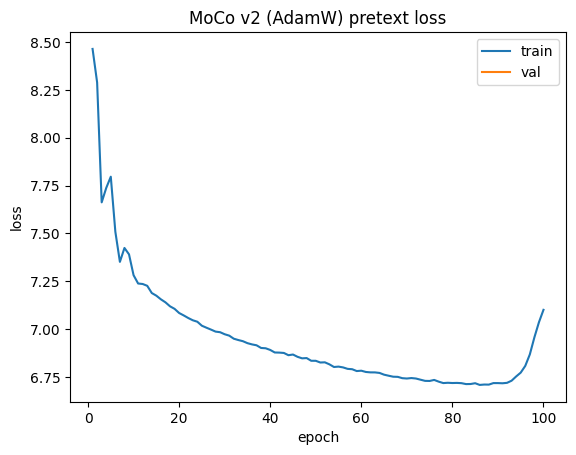

In [15]:
# Pretext loss plots

if len(hist.get("epoch", [])):
    fig = plt.figure()
    plt.plot(hist["epoch"], hist["train_loss"], label="train")
    if any([not math.isnan(v) for v in hist["val_loss"]]):
        plt.plot(hist["epoch"], [v if not math.isnan(v) else None for v in hist["val_loss"]], label="val")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.title("MoCo v2 (AdamW) pretext loss")
    plt.legend(); plt.show()

[Linear 01] train: loss=0.4138, acc=87.35% | val: loss=0.3044, acc=90.22%
[Linear 02] train: loss=0.2760, acc=90.70% | val: loss=0.2802, acc=90.81%
[Linear 03] train: loss=0.2513, acc=91.44% | val: loss=0.2595, acc=91.76%
[Linear 04] train: loss=0.2356, acc=92.01% | val: loss=0.2464, acc=91.87%
[Linear 05] train: loss=0.2219, acc=92.41% | val: loss=0.2446, acc=92.00%
[Linear 06] train: loss=0.2132, acc=92.75% | val: loss=0.2347, acc=92.19%
[Linear 07] train: loss=0.2063, acc=92.97% | val: loss=0.2254, acc=92.59%
[Linear 08] train: loss=0.1992, acc=93.23% | val: loss=0.2193, acc=92.48%
[Linear 09] train: loss=0.1938, acc=93.39% | val: loss=0.2171, acc=92.65%
[Linear 10] train: loss=0.1891, acc=93.53% | val: loss=0.2119, acc=92.81%
[Linear 11] train: loss=0.1855, acc=93.82% | val: loss=0.2127, acc=92.78%
[Linear 12] train: loss=0.1814, acc=93.85% | val: loss=0.2082, acc=92.83%
[Linear 13] train: loss=0.1764, acc=93.95% | val: loss=0.2002, acc=93.37%
[Linear 14] train: loss=0.1737, acc=94

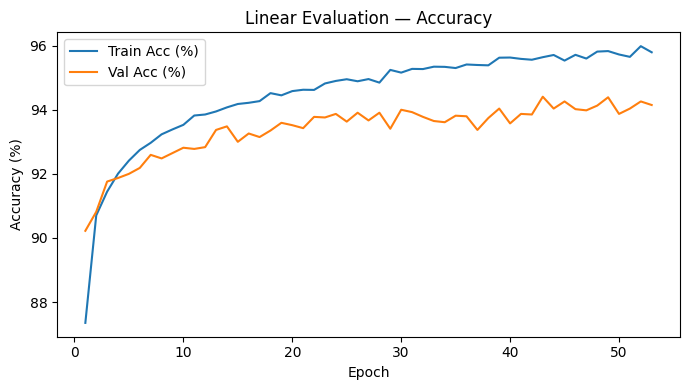

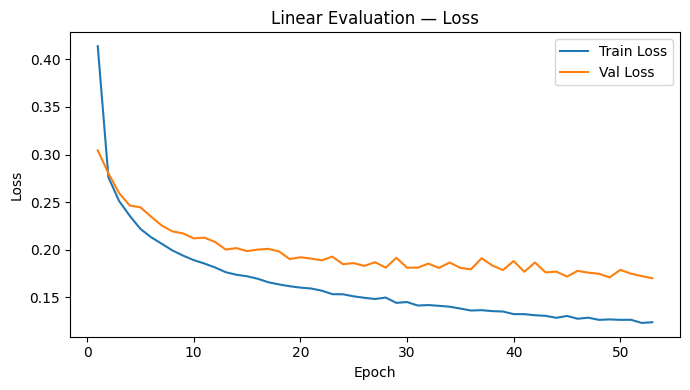

In [16]:
# Linear Evaluation  

BEST_ENC_PATH = Path(globals().get('BEST_ENC_PATH', CKPT_SAVE_DIR / "encoder_best.pth"))
BEST_CLS_PATH = CKPT_SAVE_DIR / "linear_cls_best.pth"

# --- select frozen backbone ---
encoder = encoder_q

# --- optionally load best encoder weights ---
if BEST_ENC_PATH.exists():
    ck = torch.load(str(BEST_ENC_PATH), map_location=DEVICE)
    sd = ck["encoder"] if isinstance(ck, dict) and "encoder" in ck else ck
    encoder.load_state_dict(sd, strict=False)

# --- freeze encoder ---
encoder.eval()
for p in encoder.parameters():
    p.requires_grad = False

# --- infer feature dimension once ---
with torch.no_grad():
    xb, yb = next(iter(train_cls_loader))
    xb = xb.to(DEVICE, non_blocking=True).to(memory_format=torch.channels_last)
    f  = encoder(xb)
    if isinstance(f, (list, tuple)): f = f[0]
    FEAT_DIM = f.shape[1]

# --- classifier + optimizer ---
classifier = nn.Linear(FEAT_DIM, num_classes).to(DEVICE)
opt_lin    = torch.optim.AdamW(classifier.parameters(), lr=LR_LIN, weight_decay=1e-4)

@torch.no_grad()
def eval_loss_acc(loader):
    encoder.eval(); classifier.eval()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in loader:
        x = x.to(DEVICE, non_blocking=True).to(memory_format=torch.channels_last)
        y = y.to(DEVICE, non_blocking=True)
        feats  = encoder(x)
        if isinstance(feats, (list, tuple)): feats = feats[0]
        logits = classifier(feats)
        total_loss += F.cross_entropy(logits, y, reduction="sum").item()
        correct    += (logits.argmax(1) == y).sum().item()
        total      += y.numel()
    return (total_loss / max(1, total)), (correct / max(1, total))

# --- train loop w/ early stopping on best val acc ---
hist = {"epoch": [], "train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
best_val_acc, best_epoch, no_improve = 0.0, 0, 0

for epoch in range(1, EPOCHS_LIN + 1):
    encoder.eval(); classifier.train()
    running_loss, correct_train, total_train = 0.0, 0, 0

    for x, y in train_cls_loader:
        x = x.to(DEVICE, non_blocking=True).to(memory_format=torch.channels_last)
        y = y.to(DEVICE, non_blocking=True)

        opt_lin.zero_grad(set_to_none=True)
        with torch.autocast(device_type='cuda', dtype=torch.float16, enabled=torch.cuda.is_available()):
            with torch.no_grad():
                feats = encoder(x)
                if isinstance(feats, (list, tuple)): feats = feats[0]
            logits = classifier(feats)
            loss   = F.cross_entropy(logits, y)

        loss.backward()
        opt_lin.step()

        running_loss  += loss.item() * y.size(0)
        correct_train += (logits.argmax(1) == y).sum().item()
        total_train   += y.numel()

    train_loss = running_loss / max(1, total_train)
    train_acc  = correct_train / max(1, total_train)
    val_loss, val_acc = eval_loss_acc(val_cls_loader)

    hist["epoch"].append(epoch)
    hist["train_loss"].append(train_loss)
    hist["val_loss"].append(val_loss)
    hist["train_acc"].append(train_acc * 100.0)
    hist["val_acc"].append(val_acc * 100.0)

    print(f"[Linear {epoch:02d}] train: loss={train_loss:.4f}, acc={train_acc*100:.2f}% | "
          f"val: loss={val_loss:.4f}, acc={val_acc*100:.2f}%")

    if val_acc > best_val_acc + 1e-6:
        best_val_acc, best_epoch, no_improve = val_acc, epoch, 0
        torch.save(
            {"state_dict": classifier.state_dict(), "val_acc": best_val_acc, "epoch": best_epoch,
             "feat_dim": FEAT_DIM, "num_classes": num_classes},
            str(BEST_CLS_PATH)
        )
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print("Early stop (patience reached).")
            break

print(f"Best Val Acc: {best_val_acc*100:.2f}% at epoch {best_epoch}")

plt.figure(figsize=(7,4))
plt.plot(hist["epoch"], hist["train_acc"], label="Train Acc (%)")
plt.plot(hist["epoch"], hist["val_acc"],   label="Val Acc (%)")
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)")
plt.title("Linear Evaluation — Accuracy")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
plt.plot(hist["epoch"], hist["train_loss"], label="Train Loss")
plt.plot(hist["epoch"], hist["val_loss"],   label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Linear Evaluation — Loss")
plt.legend(); plt.tight_layout(); plt.show()

In [17]:
# Final Test Accuracy + Classification Report

best_head = nn.Linear(FEAT_DIM, num_classes).to(DEVICE)
if BEST_CLS_PATH.exists():
    ck_cls = torch.load(str(BEST_CLS_PATH), map_location=DEVICE)
    best_head.load_state_dict(ck_cls["state_dict"])
else:
    best_head.load_state_dict(classifier.state_dict())

@torch.no_grad()
def _eval_test_report(encoder, head, loader, device, class_names=None):
    encoder.eval(); head.eval()
    y_true, y_pred = [], []
    for x, y in loader:
        x = x.to(device, non_blocking=True).to(memory_format=torch.channels_last)
        if torch.is_tensor(y): y = y.to(device, non_blocking=True)
        feats  = encoder(x)
        if isinstance(feats, (list, tuple)): feats = feats[0]
        logits = head(feats)
        pred   = logits.argmax(1).detach().cpu().tolist()
        y_true.extend((y.detach().cpu().tolist()) if torch.is_tensor(y) else list(y))
        y_pred.extend(pred)
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc*100:.2f} %")
    if class_names is not None:
        print(classification_report(y_true, y_pred, target_names=class_names, digits=4))
    else:
        print(classification_report(y_true, y_pred, digits=4))

_eval_test_report(encoder, best_head, test_cls_loader, DEVICE, class_names=globals().get("CLASS_NAMES", None))

Accuracy: 94.81 %
              precision    recall  f1-score   support

           0     0.9495    0.9400    0.9447       300
           1     0.9900    0.9900    0.9900       300
           2     0.8906    0.9500    0.9194       300
           3     0.9068    0.8560    0.8807       250
           4     0.9799    0.9760    0.9780       250
           5     0.9187    0.9600    0.9389       200
           6     0.9375    0.9000    0.9184       250
           7     0.9867    0.9867    0.9867       300
           8     0.9044    0.9080    0.9062       250
           9     1.0000    0.9933    0.9967       300

    accuracy                         0.9481      2700
   macro avg     0.9464    0.9460    0.9459      2700
weighted avg     0.9485    0.9481    0.9481      2700



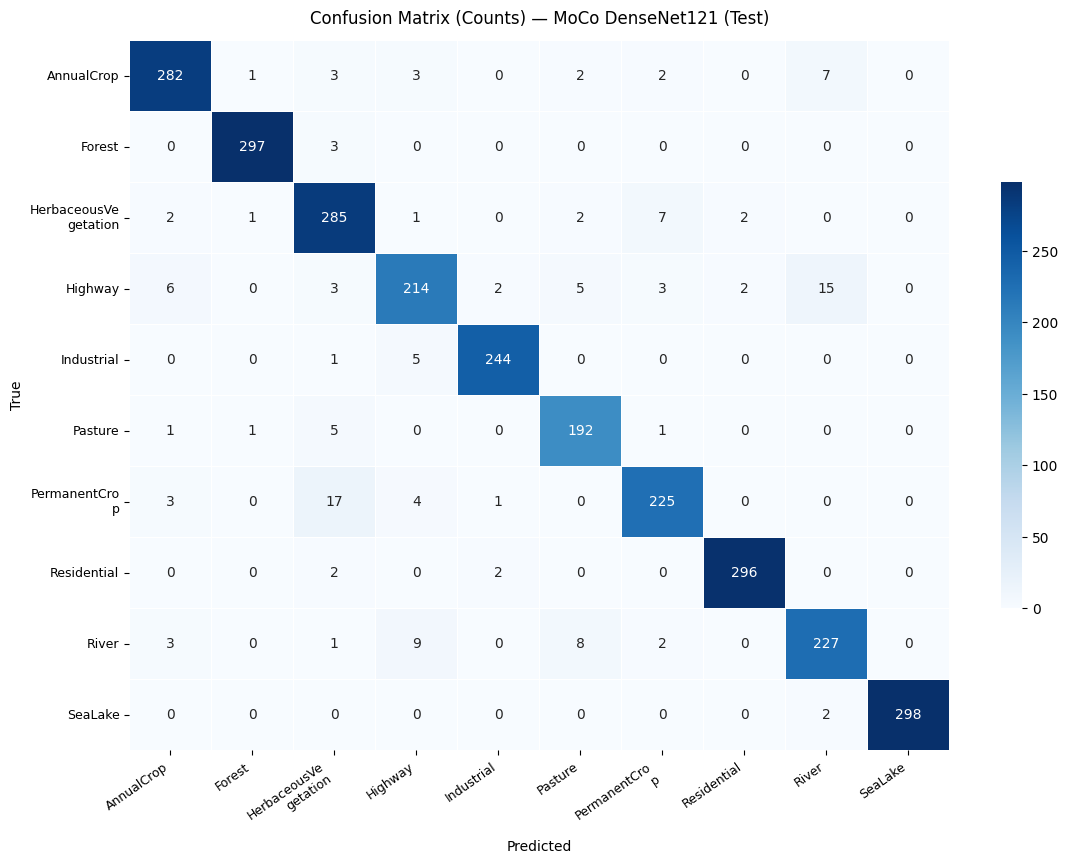

In [18]:
# =========================
# Confusion Matrix (MoCo DenseNet-121)
# =========================


# ----- class name mapping (ids -> readable names) -----
def _parent_name(p):
    try: return os.path.basename(os.path.dirname(str(p)))
    except: return None

def build_class_names(train_df, val_df, test_df, num_classes):
    names = [f"class_{i}" for i in range(num_classes)]
    big = pd.concat([train_df[["path","label"]],
                     val_df[["path","label"]],
                     test_df[["path","label"]]], ignore_index=True)
    for i in range(num_classes):
        sub = big[big["label"] == i]
        if len(sub):
            cands = sub["path"].map(_parent_name).dropna()
            if len(cands):
                names[i] = cands.value_counts().idxmax()
    return names

try:
    id2name = {v:k for k,v in classes.items()}
    CLASS_NAMES = [id2name[i] for i in range(num_classes)]
except Exception:
    CLASS_NAMES = build_class_names(train_df, val_df, test_df, num_classes)

# ----- pick the trained linear head -----
head_module = globals().get("best_head", globals().get("classifier", None))
assert head_module is not None, "Linear head (best_head/classifier) not found."

# ----- predict on TEST for CM -----
encoder.eval(); head_module.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for x, y in test_cls_loader:
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)
        feats  = encoder(x)
        if isinstance(feats, (list, tuple)): feats = feats[0]
        logits = head_module(feats)
        y_true.extend(y.detach().cpu().tolist())
        y_pred.extend(logits.argmax(1).detach().cpu().tolist())

labels = np.arange(num_classes)
cm_counts = confusion_matrix(y_true, y_pred, labels=labels)
cm_norm   = confusion_matrix(y_true, y_pred, labels=labels, normalize="true")

# nicer tick labels (wrap long names to reduce overlap)
def _wrap(lbls, width=12):
    return ["\n".join(textwrap.wrap(str(s), width=width)) for s in lbls]
wrapped = _wrap(CLASS_NAMES, width=12)

plt.figure(figsize=(12,9))
ax = sns.heatmap(pd.DataFrame(cm_counts, index=CLASS_NAMES, columns=CLASS_NAMES),
                 annot=True, fmt="d", cmap="Blues",
                 cbar_kws={"shrink":0.6}, linewidths=0.5, linecolor="white")
ax.set_title("Confusion Matrix (Counts) — MoCo DenseNet121 (Test)", pad=12)
ax.set_xlabel("Predicted"); ax.set_ylabel("True")
ax.set_xticklabels(wrapped, rotation=35, ha="right", fontsize=9)
ax.set_yticklabels(wrapped, rotation=0, va="center", fontsize=9)
plt.tight_layout(pad=2.0); plt.show()


saved /kaggle/working/moco_densenet_gradcam_000.png


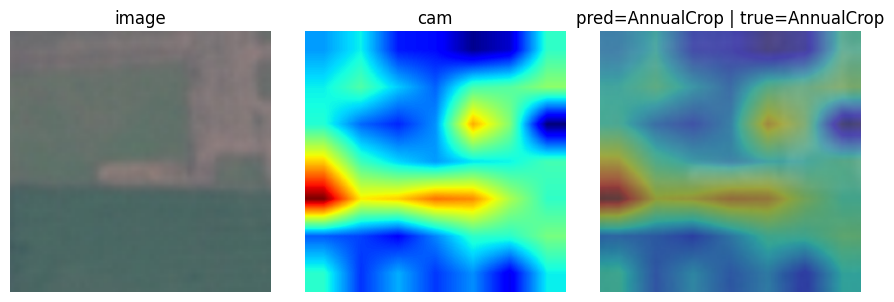

saved /kaggle/working/moco_densenet_gradcam_001.png


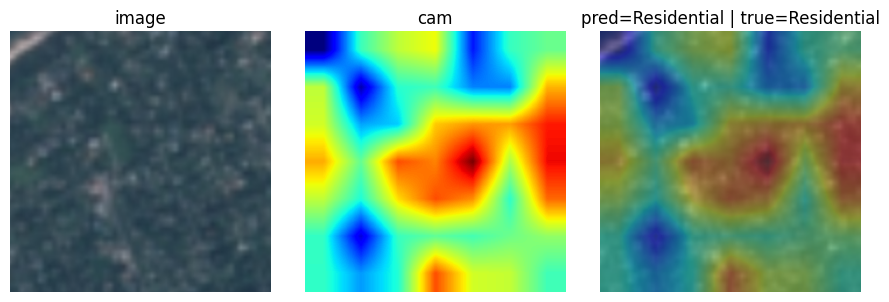

saved /kaggle/working/moco_densenet_gradcam_002.png


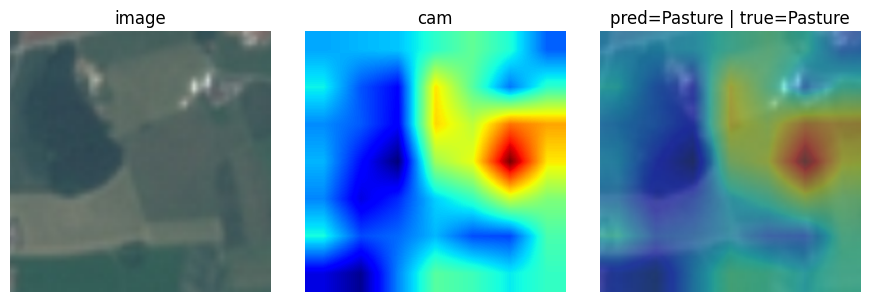

saved /kaggle/working/moco_densenet_gradcam_003.png


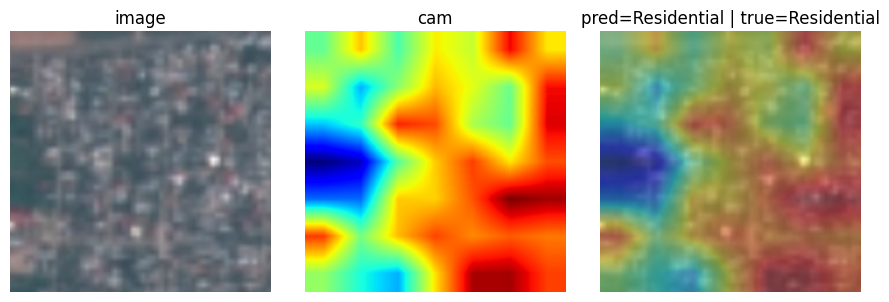

saved /kaggle/working/moco_densenet_gradcam_004.png


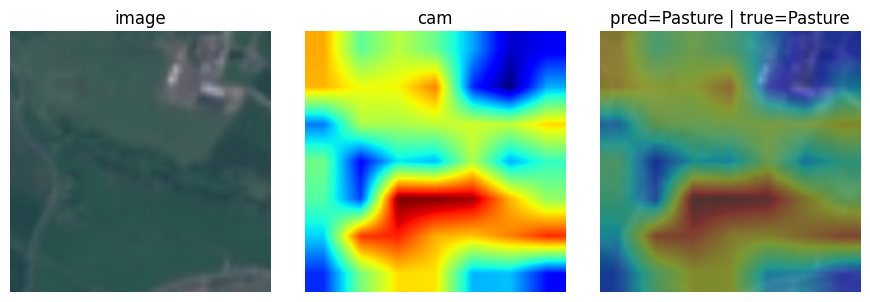

saved /kaggle/working/moco_densenet_gradcam_005.png


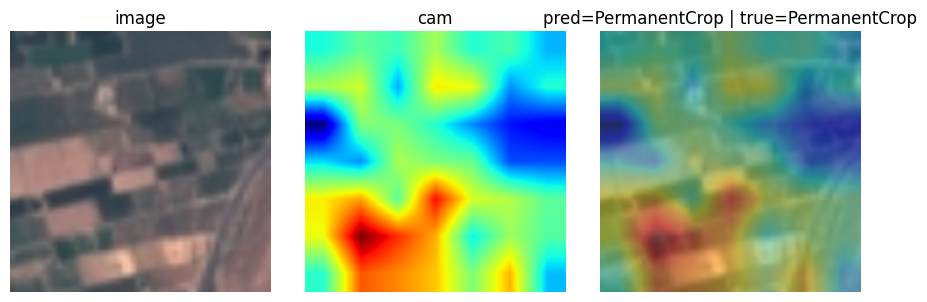

saved /kaggle/working/moco_densenet_gradcam_006.png


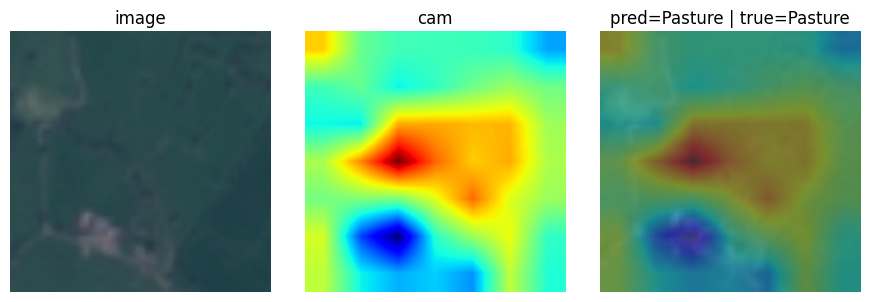

saved /kaggle/working/moco_densenet_gradcam_007.png


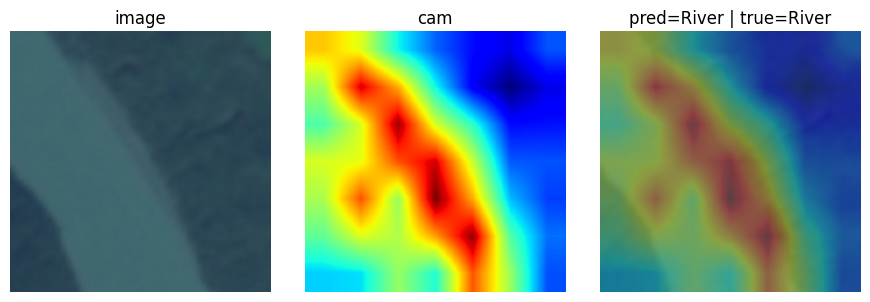

In [19]:
# =========================
# Grad-CAM (MoCo DenseNet-121 + linear head)
# =========================

# De-normalize using ImageNet stats (your eval transform used these)
IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406], device=DEVICE).view(1,3,1,1)
IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225], device=DEVICE).view(1,3,1,1)
def denorm(x): return (x * IMAGENET_STD + IMAGENET_MEAN).clamp(0, 1)

class GradCAMDenseNet:
    """
    Hook DenseNet.features → build CAM for class score from linear head.
    Assumes encoder.classifier = Identity (so encoder(x) returns pooled features).
    """
    def __init__(self, encoder_densenet, linear_head, target_module=None):
        self.encoder = encoder_densenet.eval()
        self.head = linear_head.eval()
        self.target_module = target_module or self.encoder.features  # last conv stack

        self._acts = None
        def fwd_hook(_, __, out):
            self._acts = out if not isinstance(out, (list, tuple)) else out[0]
            self._acts.retain_grad()
        self._h = self.target_module.register_forward_hook(fwd_hook)

    def remove(self): self._h.remove()

    def __call__(self, x, target_idx=None, use_relu=True):
        # forward — DO NOT use torch.no_grad()
        x = x.clone().detach().requires_grad_(True)
        feats = self.encoder(x)                   # [B, feat_dim]
        if self._acts is None:
            raise RuntimeError("No activations captured at DenseNet.features")
        logits = self.head(feats)                 # [B, num_classes]

        if target_idx is None:
            target_idx = logits.argmax(dim=1)
        else:
            target_idx = torch.as_tensor(target_idx, device=logits.device, dtype=torch.long).view(-1)
        scores = logits.gather(1, target_idx[:, None]).squeeze(1)

        self.encoder.zero_grad(set_to_none=True)
        self.head.zero_grad(set_to_none=True)
        scores.backward(torch.ones_like(scores), retain_graph=True)

        if self._acts.grad is None:
            raise RuntimeError("No gradients on target activations (remove any no_grad/inference_mode)")

        grads = self._acts.grad                       # [B,C,H,W]
        acts  = self._acts                            # [B,C,H,W]
        weights = grads.mean(dim=(2,3), keepdim=True) # [B,C,1,1]
        cam = (weights * acts).sum(dim=1, keepdim=True)
        if use_relu: cam = cam.relu()

        # per-sample normalize & upsample to input size
        B, _, H, W = cam.shape
        cam = cam.view(B, -1)
        cam = (cam - cam.min(dim=1, keepdim=True).values) / (cam.max(dim=1, keepdim=True).values - cam.min(dim=1, keepdim=True).values + 1e-8)
        cam = cam.view(B, 1, H, W)
        cam_up = F.interpolate(cam, size=x.shape[-2:], mode="bilinear", align_corners=False)
        return cam_up.squeeze(1), target_idx

def overlay_cam(img, cam, alpha=0.40):
    heat = plt.cm.jet(cam.detach().cpu().numpy())[:, :, :3]
    heat = torch.from_numpy(heat).permute(2,0,1).to(img.device, dtype=img.dtype)
    return ((1 - alpha) * img + alpha * heat).clamp(0,1)

def run_gradcam_moco_densenet(
    encoder, head_module, loader,
    class_names,
    target_mode="true",     # "true" (GT) or "pred"
    num_batches=2, max_images=8,
    use_relu=False, alpha=0.40,
    save_dir="/kaggle/working"
):
    engine = GradCAMDenseNet(encoder, head_module)
    shown = 0
    for b, (x, y) in enumerate(loader):
        if b >= num_batches or shown >= max_images: break
        # need grads → no torch.no_grad() here
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        cams, idxs = engine(x, target_idx=(y if target_mode=="true" else None), use_relu=use_relu)
        x_den = denorm(x)

        for i in range(x.size(0)):
            if shown >= max_images: break
            img = x_den[i]; cam = cams[i]
            pred_i = int(idxs[i]); true_i = int(y[i])
            p_name = class_names[pred_i]
            t_name = class_names[true_i]

            ov = overlay_cam(img, cam, alpha=alpha)
            plt.figure(figsize=(9,3))
            plt.subplot(1,3,1); plt.imshow(to_pil_image(img.cpu())); plt.axis("off"); plt.title("image")
            plt.subplot(1,3,2); plt.imshow(cam.detach().cpu().numpy(), cmap="jet"); plt.axis("off"); plt.title("cam")
            plt.subplot(1,3,3); plt.imshow(to_pil_image(ov.cpu())); plt.axis("off"); plt.title(f"pred={p_name} | true={t_name}")
            plt.tight_layout()
            if save_dir:
                out = f"{save_dir}/moco_densenet_gradcam_{shown:03d}.png"
                plt.savefig(out, dpi=150); print("saved", out)
            plt.show()
            shown += 1
    engine.remove()

# ----- RUN -----
# class names from your mapping
try:
    id2name = {v:k for k,v in classes.items()}
    CLASS_NAMES = [id2name[i] for i in range(num_classes)]
except Exception:
    CLASS_NAMES = [f"class_{i}" for i in range(num_classes)]

# pick head
head_module = globals().get("best_head", globals().get("classifier", None))
assert head_module is not None, "Linear head (best_head/classifier) not found."

run_gradcam_moco_densenet(
    encoder=encoder,                 # frozen DenseNet-121 encoder
    head_module=head_module,         # best_head / classifier
    loader=test_cls_loader,
    class_names=CLASS_NAMES,
    target_mode="true",              # "pred"
    num_batches=2, max_images=8,
    use_relu=False, alpha=0.40,
    save_dir="/kaggle/working"
)


In [20]:
# t-SNE utilities

import numpy as np
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
import plotly.express as px

@torch.no_grad()
def extract_features(encoder, loader, device):
    encoder.eval()
    feats, labels = [], []
    for batch in loader:
        if isinstance(batch, (list, tuple)) and len(batch) >= 2:
            imgs, y = batch[0], batch[1]
        elif isinstance(batch, dict) and "image" in batch and "label" in batch:
            imgs, y = batch["image"], batch["label"]
        else:
            raise RuntimeError("expected (image, label) from loader")
        imgs = imgs.to(device, non_blocking=True)
        out  = encoder(imgs)
        if isinstance(out, (list, tuple)): out = out[0]
        feats.append(out.detach().cpu())
        labels.append(torch.as_tensor(y).detach().cpu())
    X = torch.cat(feats, 0).numpy()
    y = torch.cat(labels, 0).numpy()
    return X, y

def tsne_plot_3d(X, y, title, save_html=None, n_samples=2000):
    if X.shape[0] > n_samples:
        idx = np.random.RandomState(42).choice(X.shape[0], n_samples, replace=False)
        X, y = X[idx], y[idx]
    perplexity = min(30, max(5, (int(X.shape[0]) - 1)//4))
    X_emb = TSNE(n_components=3, perplexity=perplexity, init="pca",
                 random_state=42, learning_rate="auto").fit_transform(X)
    fig = px.scatter_3d(x=X_emb[:,0], y=X_emb[:,1], z=X_emb[:,2],
                        color=y.astype(str), title=title, labels={"color":"label"})
    if save_html:
        fig.write_html(save_html)
        print(f"[t-SNE] saved -> {save_html}")
    fig.show()
    return fig

In [21]:
# Silhouette helper (cosine)

def silhouette_cosine_from_embeddings(X, y, max_n=2000):
    X = np.asarray(X)
    y = np.asarray(y)
    uniq, counts = np.unique(y, return_counts=True)
    if len(uniq) < 2 or counts.min() < 2:
        return None
    X = normalize(X, norm="l2", axis=1)
    try:
        score = silhouette_score(X, y, metric="cosine")
        return float(score)
    except Exception:
        return None

In [22]:
# t-SNE + Silhouette runs (Train / Test) 

# Use the frozen encoder from above
X_tr, y_tr = extract_features(encoder, train_cls_loader, DEVICE)
s_tr = silhouette_cosine_from_embeddings(X_tr, y_tr, max_n=2000)
title_tr = f"3D t-SNE (Train) — Silhouette(cos): {s_tr:.3f}" if s_tr is not None else "3D t-SNE (Train) — Silhouette: N/A"
_ = tsne_plot_3d(X_tr, y_tr, title_tr, save_html=str(CKPT_SAVE_DIR / "tsne3d_train.html"))
print(f"Train silhouette (cosine): {s_tr:.3f}" if s_tr is not None else "Train silhouette: N/A")

X_te, y_te = extract_features(encoder, test_cls_loader, DEVICE)
s_te = silhouette_cosine_from_embeddings(X_te, y_te, max_n=2000)
title_te = f"3D t-SNE (Test) — Silhouette(cos): {s_te:.3f}" if s_te is not None else "3D t-SNE (Test) — Silhouette: N/A"
_ = tsne_plot_3d(X_te, y_te, title_te, save_html=str(CKPT_SAVE_DIR / "tsne3d_test.html"))
print(f"Test silhouette (cosine): {s_te:.3f}" if s_te is not None else "Test silhouette: N/A")

# Optional: Validation
# X_val, y_val = extract_features(encoder, val_cls_loader, DEVICE)
# s_val = silhouette_cosine_from_embeddings(X_val, y_val, max_n=2000)
# title_val = f"3D t-SNE (Val) — Silhouette(cos): {s_val:.3f}" if s_val is not None else "3D t-SNE (Val) — Silhouette: N/A"
# _ = tsne_plot_3d(X_val, y_val, title_val, save_html=str(CKPT_SAVE_DIR / "tsne3d_val.html"))
# print(f"Val silhouette (cosine): {s_val:.3f}" if s_val is not None else "Val silhouette: N/A")

[t-SNE] saved -> /kaggle/working/moco_ckpt_v3/tsne3d_train.html


Train silhouette (cosine): 0.316
[t-SNE] saved -> /kaggle/working/moco_ckpt_v3/tsne3d_test.html


Test silhouette (cosine): 0.330
